In [1]:
# import autograd.numpy as np
# import autograd.scipy as sp

# import autograd

# import sys
# sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')

# import LinearResponseVariationalBayes as vb
# import LinearResponseVariationalBayes.ExponentialFamilies as ef

# from numpy.polynomial.hermite import hermgauss


# sys.path.insert(0, './../../../genomic_time_series_bnp/src/vb_modeling/')
# sys.path.insert(0, './../')
# import gmm_clustering_lib as gmm_utils
# import modeling_lib 
 

# from scipy import spatial
# import scipy.cluster.hierarchy as sch

# import matplotlib.pyplot as plt
# %matplotlib inline

# import time
# from tqdm import tqdm

# from copy import deepcopy

# from matplotlib.patches import Ellipse
# import matplotlib.cm as cm

# np.random.seed(453453)



In [2]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
# sys.path.insert(0, './../../../genomic_time_series_bnp/src/vb_modeling/')
sys.path.insert(0, './../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 

import functional_sensitivity_lib as fun_sens_lib
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)



# Load data

In [3]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [4]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [5]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [6]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [7]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

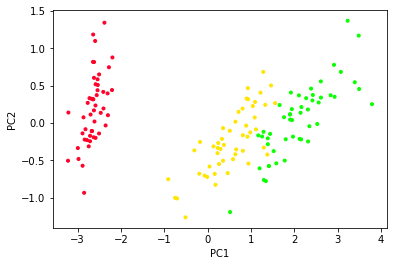

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

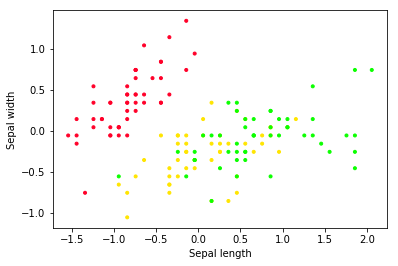

In [9]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [10]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [11]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [12]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [13]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [14]:
set_truth = False

In [15]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [16]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

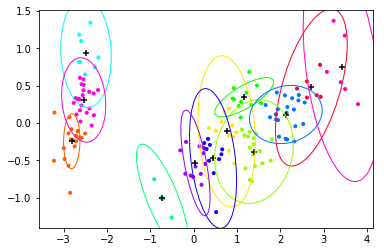

In [17]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [18]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


In [19]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [20]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0

print('done. ')

Iter: 0	 RMSE: 5.4171664084976205	 Objective: 4865.172927669948
Iter: 10	 RMSE: 10.663487726019486	 Objective: 3139.840570638689
Iter: 20	 RMSE: 11.537717178033818	 Objective: 2263.0443955658193
Iter: 30	 RMSE: 11.030946757019787	 Objective: 640.5224954576282
Iter: 40	 RMSE: 13.031531993740426	 Objective: -31.385781448850253
Iter: 50	 RMSE: 9.900303204544576	 Objective: -224.24842459009497
Iter: 60	 RMSE: 8.887730788323266	 Objective: -287.76935205287725
Iter: 70	 RMSE: 9.168777840432464	 Objective: -308.43296439711247
Iter: 80	 RMSE: 9.204747934680391	 Objective: -313.72592232799235
Iter: 90	 RMSE: 9.148647377214733	 Objective: -317.0908408178151
Iter: 100	 RMSE: 9.168596158824302	 Objective: -319.44978597507946
         Current function value: -320.229628
         Iterations: 100
         Function evaluations: 110
         Gradient evaluations: 110
Iter: 110	 RMSE: 9.147545898750307	 Objective: -320.229627514379
Iter: 120	 RMSE: 9.076998619823613	 Objective: -322.56162721193607
Iter:

In [21]:
newton_results = deepcopy(model)

In [22]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [23]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [24]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

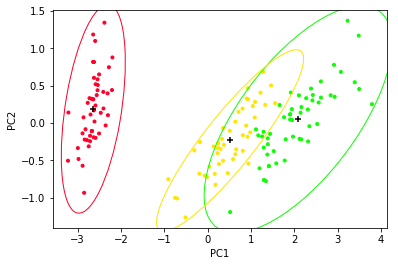

In [25]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [26]:
# import json 

# fit_dict = model.get_checkpoint_dictionary(seed=453453)

# json_output_file = '../GMM_clustering/iris_fits/full_data_fits/iris_bnp_full_data_fit.json'
# print('saving fit dict to ', json_output_file)

# with open(json_output_file, 'w') as outfile:
#     json.dump(fit_dict, outfile)


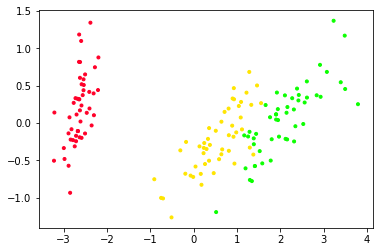

In [27]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

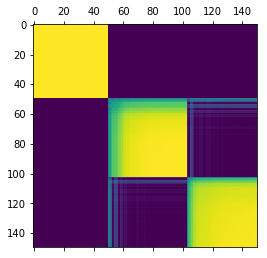

In [27]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [28]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

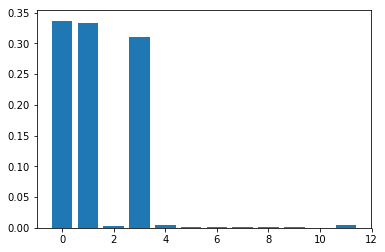

In [29]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

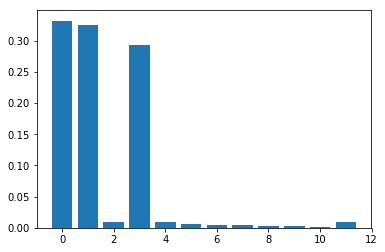

In [30]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  2.,   0.,   1.,   1.,   1.,   5.,   2.,   2.,   6., 130.]),
 array([0.44352936, 0.49917643, 0.55482349, 0.61047055, 0.66611762,
        0.72176468, 0.77741174, 0.83305881, 0.88870587, 0.94435294,
        1.        ]),
 <a list of 10 Patch objects>)

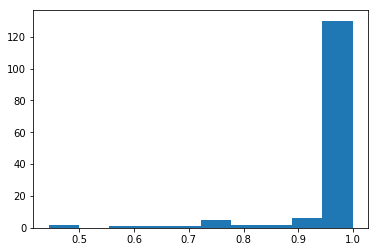

In [31]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Lets look at a few random restarts, see how results chage

In [101]:
n_restarts = 6
init_global_free_param_array = []
global_free_param_array = []

for i in tqdm(range(n_restarts)):
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500, disp=True)
    
    init_global_free_param_array.append(init_global_free_param)
    global_free_param_array.append(best_param)



  0%|          | 0/6 [00:00<?, ?it/s]

Iter: 0	 RMSE: 6.5468931561400385	 Objective: 10712.4428186868
Iter: 10	 RMSE: 12.386511213166564	 Objective: 5408.521751575837
Iter: 20	 RMSE: 15.595164522287995	 Objective: 3243.2217893511674
Iter: 30	 RMSE: 16.66521434393147	 Objective: 274.88176882271654
Iter: 40	 RMSE: 13.234308161611917	 Objective: -148.48391682730193
Iter: 50	 RMSE: 12.483880311174584	 Objective: -240.01709828470186
Iter: 60	 RMSE: 12.547716520216344	 Objective: -277.1635960944732
Iter: 70	 RMSE: 12.18464812920785	 Objective: -293.89596750832436
Iter: 80	 RMSE: 10.94970395670163	 Objective: -299.9028178333344
Iter: 90	 RMSE: 10.145802561530266	 Objective: -304.5564511242407
Iter: 100	 RMSE: 10.181616975263603	 Objective: -306.24576004316606
         Current function value: -307.606158
         Iterations: 100
         Function evaluations: 108
         Gradient evaluations: 108
Iter: 110	 RMSE: 10.165734771282187	 Objective: -311.48526408182875
Iter: 120	 RMSE: 9.740319759155842	 Objective: -319.004319899586
   

 17%|█▋        | 1/6 [00:44<03:41, 44.21s/it]

Iter: 130	 RMSE: 9.708062311575146	 Objective: -319.17124929632513
         Current function value: -319.171249
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.706459610399506e-14, f_diff = 1.4210854715202004e-12
Iter: 0	 RMSE: 6.358344843865595	 Objective: 4614.971025372345
Iter: 10	 RMSE: 7.18186673322631	 Objective: 3238.6958715285755
Iter: 20	 RMSE: 9.989685235837284	 Objective: 1826.4506292677734
Iter: 30	 RMSE: 14.096514338167907	 Objective: 404.69306015300344
Iter: 40	 RMSE: 9.887070525161473	 Objective: -80.50913361864949
Iter: 50	 RMSE: 8.335703868142676	 Objective: -236.02096286409085
Iter: 60	 RMSE: 8.122496717560521	 Objective: -290.3689099601698
Iter: 70	 RMSE: 8.037671114807365	 Objective: -306.15936384252143
Iter: 80	 RMSE: 8.017658238405676	 Objective: -317.26153237215186
Iter: 90	 RMSE: 7.988227760651222	 Objective: -322.39896311596
Iter: 100	 RMSE: 7.863923072255739	 Objective:

 33%|███▎      | 2/6 [01:28<02:56, 44.06s/it]

         Current function value: -329.486602
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 4.8017308445363893e-14, f_diff = 1.0231815394945443e-12
Iter: 0	 RMSE: 6.028464205476297	 Objective: 4677.353654982866
Iter: 10	 RMSE: 7.78285095957768	 Objective: 3087.0938693430408
Iter: 20	 RMSE: 8.578770816043578	 Objective: 1208.8398289880179
Iter: 30	 RMSE: 9.777139891143474	 Objective: 41.08775403240213
Iter: 40	 RMSE: 9.304491000395329	 Objective: -183.338252753373
Iter: 50	 RMSE: 9.426970033228173	 Objective: -237.14514542033226
Iter: 60	 RMSE: 9.611250933524408	 Objective: -266.33884748657323
Iter: 70	 RMSE: 9.939329514280903	 Objective: -282.63299031503664
Iter: 80	 RMSE: 10.204308965324813	 Objective: -297.2902485658555
Iter: 90	 RMSE: 9.869409968081957	 Objective: -303.55837045550044
Iter: 100	 RMSE: 9.078768781644973	 Objective: -307.1449021498806
         Current function value: -309.007293


 50%|█████     | 3/6 [02:18<02:18, 46.12s/it]

         Current function value: -321.267139
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 6.044492163737036e-14, f_diff = 1.3642420526593924e-12
Iter: 0	 RMSE: 6.214426079086642	 Objective: 4866.803853301887
Iter: 10	 RMSE: 8.3832412980675	 Objective: 3117.016919770475
Iter: 20	 RMSE: 16.50752366837857	 Objective: 1700.3969439718667
Iter: 30	 RMSE: 25.729704569207946	 Objective: 393.54792733033173
Iter: 40	 RMSE: 21.011620859338684	 Objective: 61.18479874149011
Iter: 50	 RMSE: 13.069246556388778	 Objective: -180.52459365866562
Iter: 60	 RMSE: 12.171563557051629	 Objective: -255.21446165437342
Iter: 70	 RMSE: 12.351807352406887	 Objective: -283.95033922660224
Iter: 80	 RMSE: 12.333787292648424	 Objective: -290.66338482945076
Iter: 90	 RMSE: 12.134286400767719	 Objective: -295.6145412929119
Iter: 100	 RMSE: 11.620660328510452	 Objective: -300.6870015396195
         Current function value: -304.10

 67%|██████▋   | 4/6 [02:55<01:27, 43.96s/it]

         Current function value: -310.694442
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 4.729766925337664e-14, f_diff = 5.684341886080801e-13
Iter: 0	 RMSE: 5.9339584258766065	 Objective: 10726.972287969946
Iter: 10	 RMSE: 7.122180628737496	 Objective: 6203.831158491058
Iter: 20	 RMSE: 8.945113305827249	 Objective: 4982.4479562705255
Iter: 30	 RMSE: 14.122310220978584	 Objective: 1506.5536446399078
Iter: 40	 RMSE: 13.216207797629702	 Objective: 409.8626816383093
Iter: 50	 RMSE: 13.461688847096001	 Objective: 134.86562528901464
Iter: 60	 RMSE: 12.482726860044194	 Objective: -111.09601424175355
Iter: 70	 RMSE: 12.440542090999083	 Objective: -231.9820533772747
Iter: 80	 RMSE: 12.442333324819755	 Objective: -274.8789161409917
Iter: 90	 RMSE: 12.426556935684134	 Objective: -283.9722971889124
Iter: 100	 RMSE: 12.392104425898692	 Objective: -291.48125865447935
         Current function value: -294.5

 83%|████████▎ | 5/6 [03:57<00:47, 47.41s/it]

         Current function value: -309.039217
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.964117546185255e-14, f_diff = 7.389644451905042e-13
Iter: 0	 RMSE: 5.466373437868433	 Objective: 4712.171151889832
Iter: 10	 RMSE: 10.646064861302088	 Objective: 2939.459291689301
Iter: 20	 RMSE: 16.344109472126252	 Objective: 1201.3705971006038
Iter: 30	 RMSE: 14.697260207062277	 Objective: -28.256636703756186
Iter: 40	 RMSE: 12.153844718679027	 Objective: -254.02319670152437
Iter: 50	 RMSE: 11.267455712883047	 Objective: -293.2049809179358
Iter: 60	 RMSE: 10.434360873408144	 Objective: -302.8047929290454
Iter: 70	 RMSE: 10.313278929607169	 Objective: -307.1097445374311
Iter: 80	 RMSE: 10.21028013103178	 Objective: -310.44205612235316
Iter: 90	 RMSE: 9.984201223510535	 Objective: -313.04835275907277
Iter: 100	 RMSE: 10.007034251854849	 Objective: -316.56996903103214
         Current function value: -317

100%|██████████| 6/6 [06:15<00:00, 62.51s/it]

Iter: 210	 RMSE: 7.749295103233213	 Objective: -330.9163161997794
         Current function value: -330.916316
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 2: x_diff = 1.5837606777273383e-06, f_diff = 7.389644451905042e-13


final objective val, restart 0:  -319.17124929632513
final objective val, restart 1:  -329.48660190645614
final objective val, restart 2:  -321.2671393054586
final objective val, restart 3:  -310.6944415655437
final objective val, restart 4:  -309.03921670590114
final objective val, restart 5:  -330.9163161997811


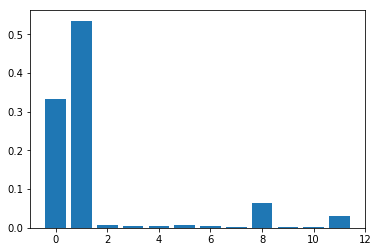

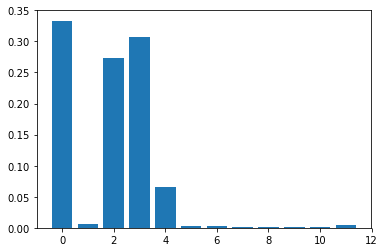

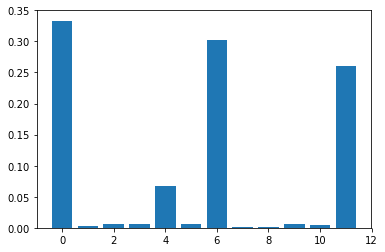

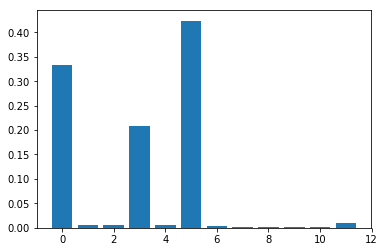

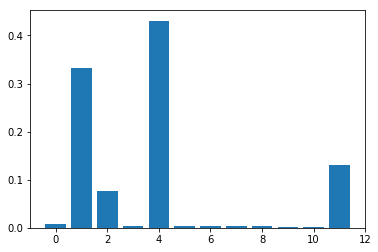

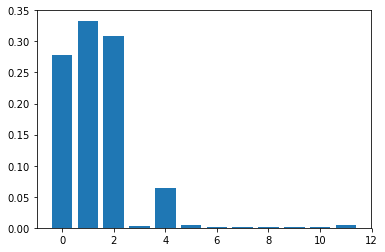

In [102]:
# get cluster assignments
cluster_assignments_array = []
bnp_centroids_pc_array = []
bnp_cluster_covs_pc_array = []

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    bnp_centroids_pc_, bnp_cluster_covs_pc_ = \
        transform_params_to_pc_space(pca_fit, \
                                     model.vb_params['global']['centroids'].get(),\
                                     np.linalg.inv(model.vb_params['global']['gamma'].get()))
        
    bnp_centroids_pc_array.append(bnp_centroids_pc_)
    bnp_cluster_covs_pc_array.append(bnp_cluster_covs_pc_)
    
    cluster_assignments_array.append(np.argmax(model.vb_params['e_z'].get(), axis = 1))
    
    plt.figure()
    cluster_weights = np.sum(model.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
    plt.bar(np.arange(len(cluster_weights)), cluster_weights); 
    
#     plt.figure()
#     plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))
    
    print('final objective val, restart {}: '.format(i), model.set_z_get_kl())

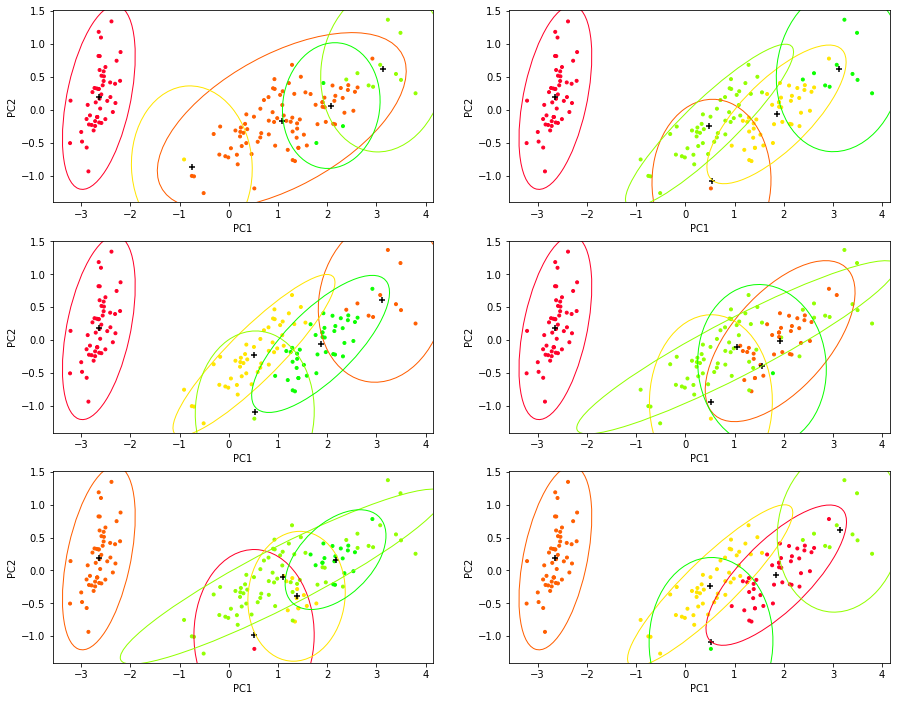

In [103]:
f, axarr = plt.subplots(3, 2, figsize = (15, 12))

for i in range(n_restarts): 
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2
    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments_array[i], \
                  colors2, axarr[axarr_indx1, axarr_indx2], 
                 centroids = bnp_centroids_pc_array[i][:, np.unique(cluster_assignments_array[i])], \
                 cov = bnp_cluster_covs_pc_array[i][np.unique(cluster_assignments_array[i])])
    axarr[axarr_indx1, axarr_indx2].set_xlabel('PC1')
    axarr[axarr_indx1, axarr_indx2].set_ylabel('PC2')

In [49]:
# %%R
# # an R multiplot function
# multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
#   library(grid)

#   # Make a list from the ... arguments and plotlist
#   plots <- c(list(...), plotlist)

#   numPlots = length(plots)

#   # If layout is NULL, then use 'cols' to determine layout
#   if (is.null(layout)) {
#     # Make the panel
#     # ncol: Number of columns of plots
#     # nrow: Number of rows needed, calculated from # of cols
#     layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
#                     ncol = cols, nrow = ceiling(numPlots/cols))
#   }

#  if (numPlots==1) {
#     print(plots[[1]])

#   } else {
#     # Set up the page
#     grid.newpage()
#     pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

#     # Make each plot, in the correct location
#     for (i in 1:numPlots) {
#       # Get the i,j matrix positions of the regions that contain this subplot
#       matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

#       print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
#                                       layout.pos.col = matchidx$col))
#     }
#   }
# }


In [50]:
# %%R -i cluster_assignments_array -i n_restarts -w 5 -h 8 --units in -r 200
# # pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# # pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# plot_list <- list()
# for(i in 1:n_restarts){
#     # add our bnp clusterings to the dataframe
#     # print(cluster_assignments_array[, i])
#     df_pca$bnp_clusters <- as.factor(cluster_assignments_array[, i])
    
#     plot <- ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#      theme(legend.position="none") 
    
#     plot_list[[i]] <- plot
# }

# # plot_list[[1]]

# multiplot(plotlist = plot_list, cols = 2)

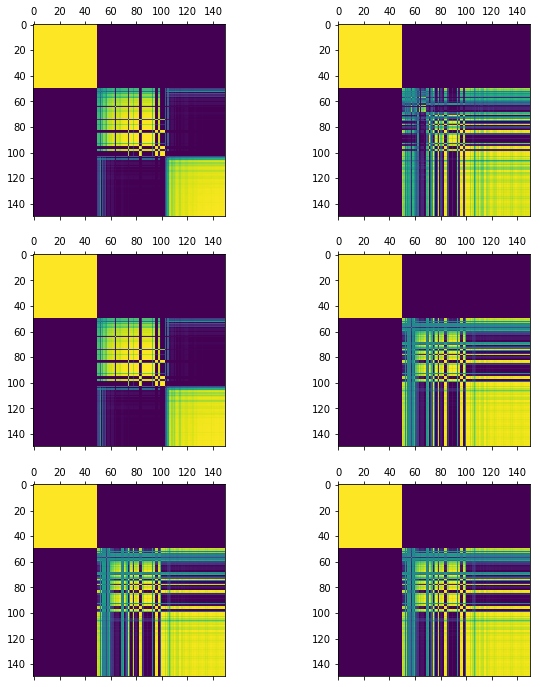

In [59]:
f, axarr = plt.subplots(3, 2, figsize=(10, 12))

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    e_z = model.vb_params['e_z'].get()
    co_cluster_mat = np.dot(e_z, e_z.T)
    
#     if i == 0: 
#         dis = (co_cluster_mat + 1) ** (-1)
#         dis[np.diag_indices_from(dis)] = 0
#         dis = spatial.distance.squareform(dis, checks=False)
#         y = sch.linkage(dis, method='average')
#         indx = sch.dendrogram(y, no_plot=True)["leaves"]
    
    co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]
    
    fig_indx1 = int(np.floor(i / 2))
    fig_indx2 = int(i % 2)
    axarr[fig_indx1, fig_indx2].matshow(co_cluster_mat)
    

# Parametric sensitivity

In [32]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = gmm_utils.LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [33]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [34]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


0.07230487288465931 2452.4187642002566


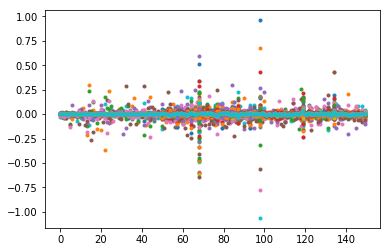

In [35]:
# sensitivity to data
plt.plot(linear_sens.data_sens_mat.T, '.');


In [36]:
# Choose a prior parameter and check the sensitivity
print('prior indices')
print(model.prior_indices)

prior_ind = 0 # this is the alpha, the parameter for the dp prior

epsilon = 0.5


prior indices
prior_params:
	alpha: [0]
	prior_centroid_mean: [1]
	prior_centroid_info: [2]
	prior_gamma_df: [3]
	prior_gamma_inv_scale:
[[ 4.  5.  7. 10.]
 [ 5.  6.  8. 11.]
 [ 7.  8.  9. 12.]
 [10. 11. 12. 13.]]


In [37]:
model_perturbed = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = epsilon

model_perturbed.prior_params.set_vector(
    model_perturbed.prior_params.get_vector() + perturb_vec)

pert_opt_free_param = \
    model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -320.3130274238318
Iter: 10	 RMSE: 9.006891497109777	 Objective: -320.36211128898896
Iter: 20	 RMSE: 9.004298558562148	 Objective: -320.38901035474015
Iter: 30	 RMSE: 9.001501522686333	 Objective: -320.40946931935883
Iter: 40	 RMSE: 9.000341708997654	 Objective: -320.41815726096706
Iter: 50	 RMSE: 8.998539403920203	 Objective: -320.4233339230133
Iter: 60	 RMSE: 8.99786267989399	 Objective: -320.424139792795
Iter: 70	 RMSE: 8.99813082593391	 Objective: -320.4241865719608
Iter: 80	 RMSE: 8.998106940574877	 Objective: -320.4241873766693
Optimization terminated successfully.
         Current function value: -320.424187
         Iterations: 66
         Function evaluations: 88
         Gradient evaluations: 88
Iter: 90	 RMSE: 8.998111303693303	 Objective: -320.42418738753474
         Current function value: -320.424187
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: 

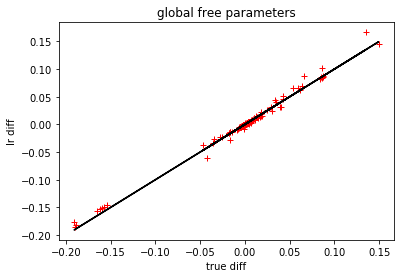

In [38]:
free_perturb_vec = model_perturbed.prior_params.get_free() - model.prior_params.get_free()
lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

diff_vec = pert_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')
plt.title('global free parameters')


In [39]:
print(linear_sens.moment_model.moment_params['v_sticks'])

v_sticks:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


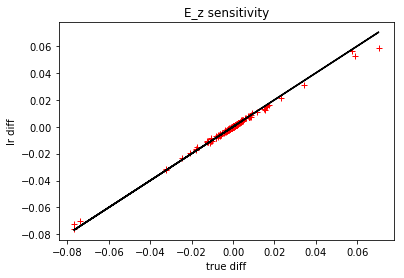

In [40]:
## check e_z sensitivity

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
# cluster_weights_orig = np.mean(e_z_orig, axis = 0)
cluster_weights_orig = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
# cluster_weights_pert = np.mean(e_z_pert, axis = 0)
cluster_weights_pert = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
# cluster_weights_lr = np.mean(e_z_lr, axis = 0)
cluster_weights_lr = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

diff_vec = (e_z_pert - e_z_orig).flatten()
lr_diff_vec = (e_z_lr - e_z_orig).flatten()

plt.title('E_z sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


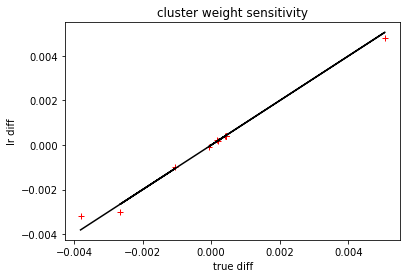

In [41]:
# check sensitivity of cluster weights

diff_vec = (np.sort(cluster_weights_pert) - np.sort(cluster_weights_orig)).flatten()
lr_diff_vec = (np.sort(cluster_weights_lr) - np.sort(cluster_weights_orig)).flatten()

plt.title('cluster weight sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


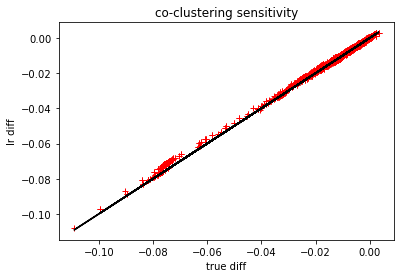

In [42]:
# check co-clustering sensitivity
coclustering_orig = np.matmul(e_z_orig, e_z_orig.T)
coclustering_pert = np.matmul(e_z_pert, e_z_pert.T)
coclustering_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (coclustering_pert - coclustering_orig).flatten()
lr_diff_vec = (coclustering_lr - coclustering_orig).flatten()


plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


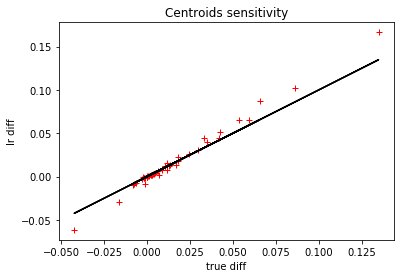

In [43]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_beta_lr = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec = (e_beta_pert - e_beta_orig).flatten()
lr_diff_vec = (e_beta_lr - e_beta_orig).flatten()

plt.title('Centroids sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [44]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [45]:
get_e_number_clusters_from_free_par(model, newton_results.global_vb_params.get_free())

6.290618592748502

In [46]:
get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)

6.510199785073705

In [47]:
get_e_number_clusters_from_free_par(model, pert_opt_free_param)

6.5198715234615925

# check how well the linear approximation holds over a range of epsilons

In [50]:
epsilons = [-3, -2, -1.5, -1, -0.5, 0.5, 1, 2, 4, 6]

In [51]:
len(epsilons)

10

In [52]:
pert_opt_free_param_list = []
pert_prior_free_params_list = []

# re-optimize for each epsilon
for i in range(len(epsilons)): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
    perturb_vec[prior_ind] = epsilons[i]

    model_perturbed.prior_params.set_vector(
        newton_results.prior_params.get_vector() + perturb_vec)
    # print(model_perturbed.prior_params.get_vector())
    
    pert_prior_free_params_list.append(model_perturbed.prior_params.get_free())
    
    pert_opt_free_param_list.append(
        model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = False)[0])


optimizing when epsilon = -3
optimizing when epsilon = -2
optimizing when epsilon = -1.5
optimizing when epsilon = -1
optimizing when epsilon = -0.5
optimizing when epsilon = 0.5
optimizing when epsilon = 1
optimizing when epsilon = 2
optimizing when epsilon = 4
optimizing when epsilon = 6


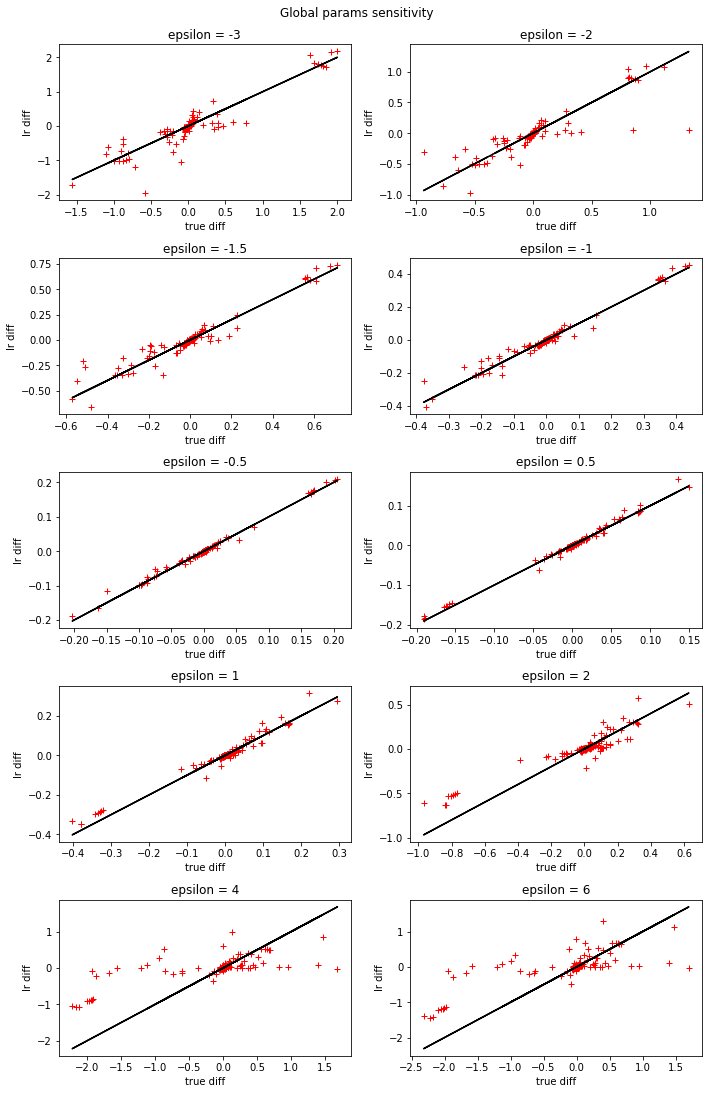

In [53]:
# check global params

linear_sens.moment_model.set_moments_from_free_par(best_param)


f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
    
    # diff in prior free params
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    
    # get linear response global free params
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    lr_diff_vec = (lr_free_param_diff_vec).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


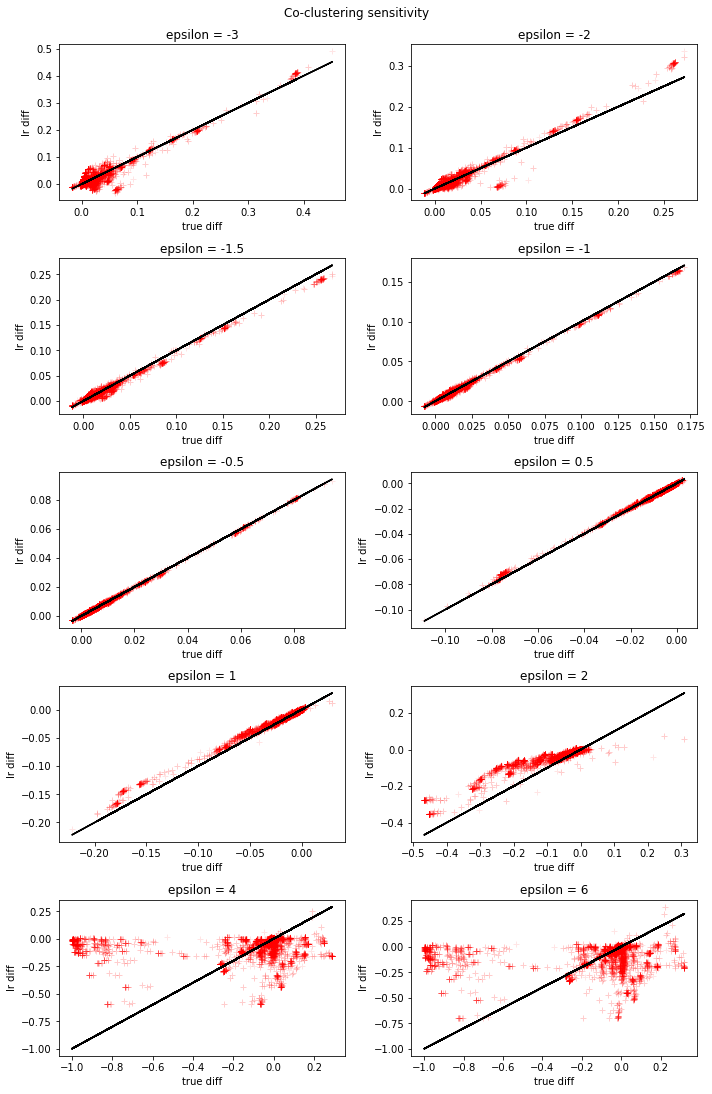

In [55]:
# check e_z's 

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Co-clustering sensitivity')

for i in range(len(epsilons)): 
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)
    
    
    linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
    e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)
    
#     diff_vec = (e_z_pert - e_z_orig).flatten()
#     lr_diff_vec = (e_z_lr - e_z_orig).flatten()

    diff_vec = (co_cluster_pert - co_cluster_og).flatten()
    lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()

    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+', alpha = 0.1)
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    # axarr[indx1, indx2].set_xlim([-0.06, 0.06])
    
f.tight_layout()
blah.set_y(1.01)


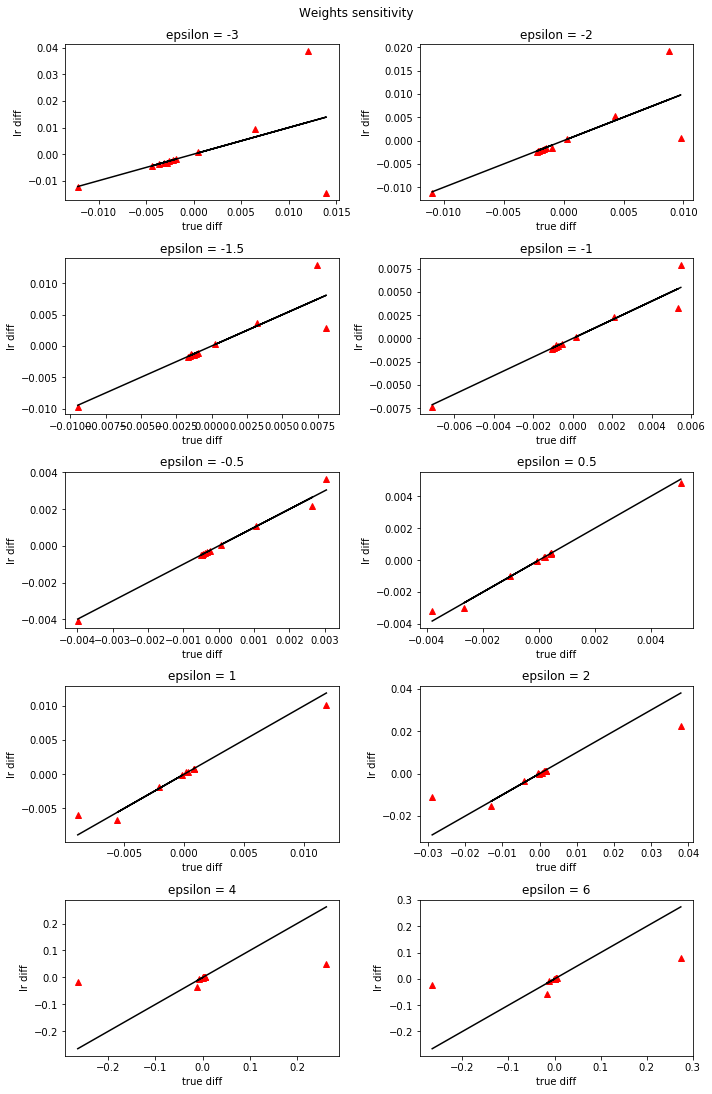

In [69]:
# check weights's 

linear_sens.moment_model.set_moments_from_free_par(best_param)
weights_og = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Weights sensitivity')

for i in range(len(epsilons)): 
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    weights_pert = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))
    
    linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
    weights_lr = modeling_lib.get_mixture_weights(\
                            sp.special.expit(linear_sens.moment_model.moment_params['v_sticks'].get()))
    
#     diff_vec = (e_z_pert - e_z_orig).flatten()
#     lr_diff_vec = (e_z_lr - e_z_orig).flatten()

    diff_vec = (weights_pert - weights_og).flatten()
    lr_diff_vec = (weights_lr - weights_og).flatten()

    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r^')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    # axarr[indx1, indx2].set_xlim([-0.06, 0.06])
    
f.tight_layout()
blah.set_y(1.01)


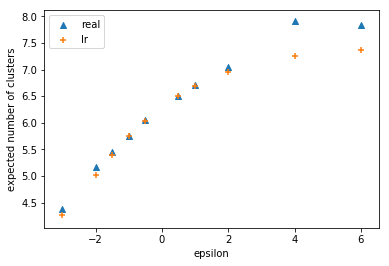

In [88]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.legend(('real', 'lr'))
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

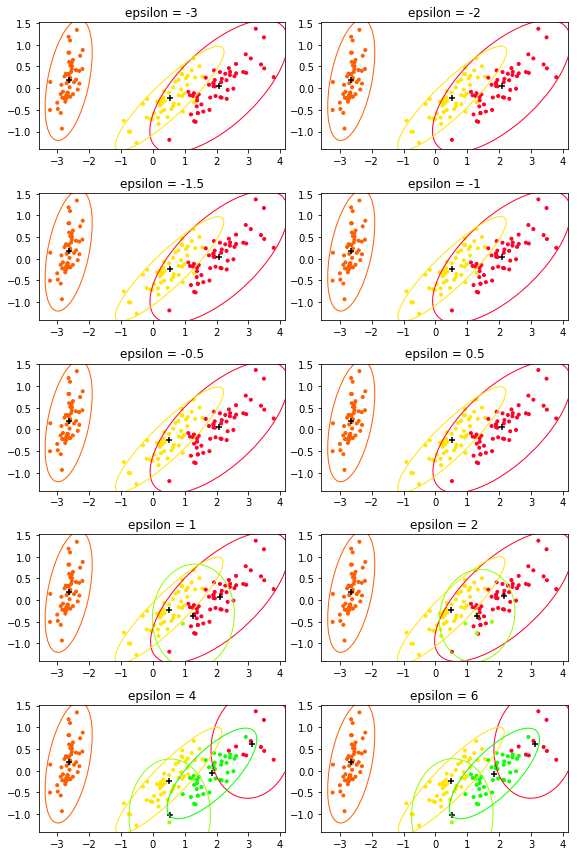

In [52]:
f, axarr = plt.subplots(int(len(epsilons)/2), 2, figsize = (8, 12))

for i in range(len(epsilons)): 
    
    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    cluster_assignments = np.argmax(e_z_pert, axis = 1)
    
    centroids = linear_sens.moment_model.moment_params['centroids'].get()
    covs = np.linalg.inv(linear_sens.moment_model.model.vb_params['global']['gamma'].get())

    pc_centroids, pc_covs = transform_params_to_pc_space(pca_fit, centroids, covs)
    
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2

    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments, \
                  colors2, axarr[axarr_indx1, axarr_indx2], 
                 centroids = pc_centroids[:, np.unique(cluster_assignments)], \
                 cov = pc_covs[np.unique(cluster_assignments)])
    axarr[axarr_indx1, axarr_indx2].set_title('epsilon = {}'.format(epsilons[i]))
    
f.tight_layout()


In [82]:
model.set_from_global_free_par(pert_opt_free_param_list[-1])
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx = sch.dendrogram(y, no_plot=True)["leaves"]


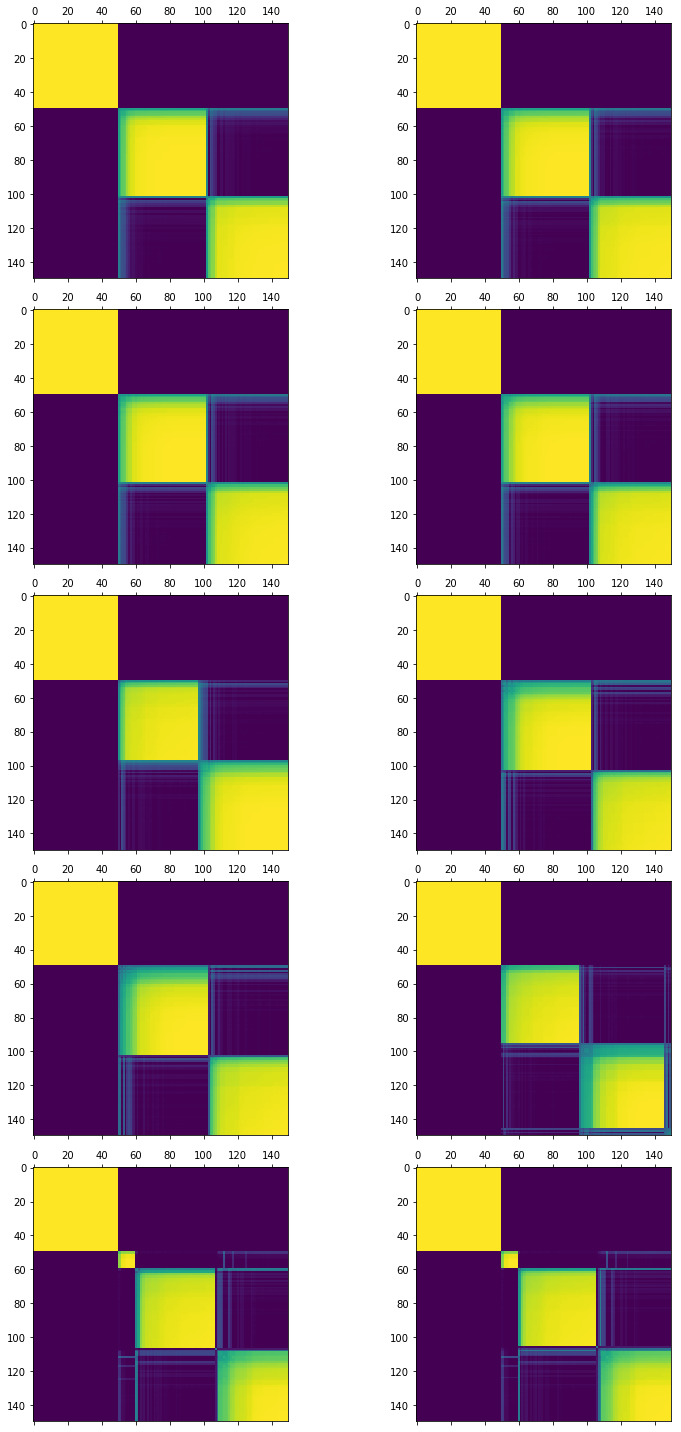

In [86]:
f, axarr = plt.subplots(5, 2, figsize=(12, 20))

for i in range(len(epsilons)): 
    model.set_from_global_free_par(pert_opt_free_param_list[i])
    e_z = model.vb_params['e_z'].get()
    co_cluster_mat = np.dot(e_z, e_z.T)
    
    dis = (co_cluster_mat + 1) ** (-1)
    dis[np.diag_indices_from(dis)] = 0
    dis = spatial.distance.squareform(dis, checks=False)
    y = sch.linkage(dis, method='average')
    indx = sch.dendrogram(y, no_plot=True)["leaves"]
    
    co_cluster_mat = co_cluster_mat[indx][:, indx]
    
    fig_indx1 = int(np.floor(i / 2))
    fig_indx2 = int(i % 2)
    axarr[fig_indx1, fig_indx2].matshow(co_cluster_mat)

f.tight_layout()


### what if we perturb and start from a different initialization 

In [112]:
model_perturbed2 = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = 0.5

model_perturbed2.prior_params.set_vector(
    model.prior_params.get_vector() + perturb_vec)

print(model_perturbed2.prior_params.get_vector())
print(model_perturbed2.prior_indices)


print('k-means initialization ...')
t0 = time.time()
init_global_free_param = model_perturbed2.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
t_kmeans = time.time() - t0

pert_opt_free_param2 = \
    model_perturbed2.optimize_full(init_global_free_param, init_max_iter=100, final_max_iter=500)[0]


[1.5 0.  0.1 8.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1. ]
prior_params:
	alpha: [0]
	prior_centroid_mean: [1]
	prior_centroid_info: [2]
	prior_gamma_df: [3]
	prior_gamma_inv_scale:
[[ 4.  5.  7. 10.]
 [ 5.  6.  8. 11.]
 [ 7.  8.  9. 12.]
 [10. 11. 12. 13.]]
k-means initialization ...
Iter: 0	 RMSE: 5.924091381221903	 Objective: 7519.573594239765
Iter: 10	 RMSE: 8.381054885028085	 Objective: 4421.849717035486
Iter: 20	 RMSE: 10.345345114299814	 Objective: 1035.877627059759
Iter: 30	 RMSE: 17.507463419619288	 Objective: 143.35461257573837
Iter: 40	 RMSE: 11.72247857867356	 Objective: -59.52772754629132
Iter: 50	 RMSE: 9.56699093307698	 Objective: -145.57170688367347
Iter: 60	 RMSE: 8.666841569053313	 Objective: -184.68207144772498
Iter: 70	 RMSE: 8.16607183338157	 Objective: -216.1934997325391
Iter: 80	 RMSE: 8.102264895578793	 Objective: -227.28812607914352
Iter: 90	 RMSE: 7.867785647173199	 Objective: -235.91134693216264
Iter: 100	 RMSE: 7.914399207836115	 Objective: -239.2834953152996

In [113]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

# results when starting from original optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)

# results when starting from random new optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param2)
e_z_pert2 = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert2 = np.matmul(e_z_pert2, e_z_pert2.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_cluster_pert2 - co_cluster_og).flatten()
lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()


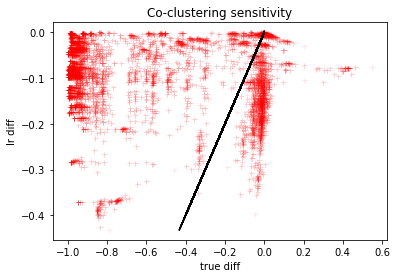

In [114]:
#indx = np.abs(diff_vec) < 0.008
plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


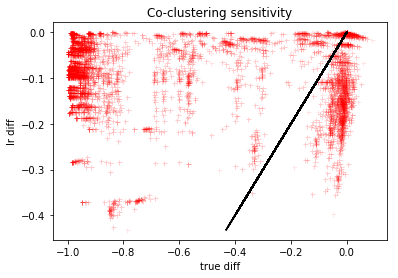

In [115]:
# Lets look at co-clustering again, but subsetting to 
# those with confident cluster belonings

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()

sure_indx = np.argwhere(np.max(e_z_orig, axis = 1) > 0.9).flatten()

co_cluster_sure_og = np.matmul(e_z_orig[sure_indx, :], e_z_orig[sure_indx, :].T)
co_cluster_sure_pert2 = np.matmul(e_z_pert2[sure_indx, :], e_z_pert2[sure_indx, :].T)
co_cluster_sure_lr = np.matmul(e_z_lr[sure_indx, :], e_z_lr[sure_indx, :].T)

diff_vec = (co_cluster_sure_pert2 - co_cluster_sure_og).flatten()
lr_diff_vec = (co_cluster_sure_lr - co_cluster_sure_og).flatten()

plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


# Functional Sensitivty

In [48]:
best_param = newton_results.global_vb_params.get_free()

In [49]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))
for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

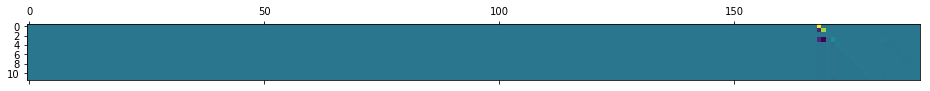

In [50]:
plt.matshow(g_eta)

In [51]:
model.set_from_global_free_par(best_param)
e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

for i in range(k_approx): 
    assert np.abs(get_kth_weight_from_free_param(model, best_param, i) - \
                        modeling_lib.get_mixture_weights(e_sticks)[i]) < 1e-12

In [52]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


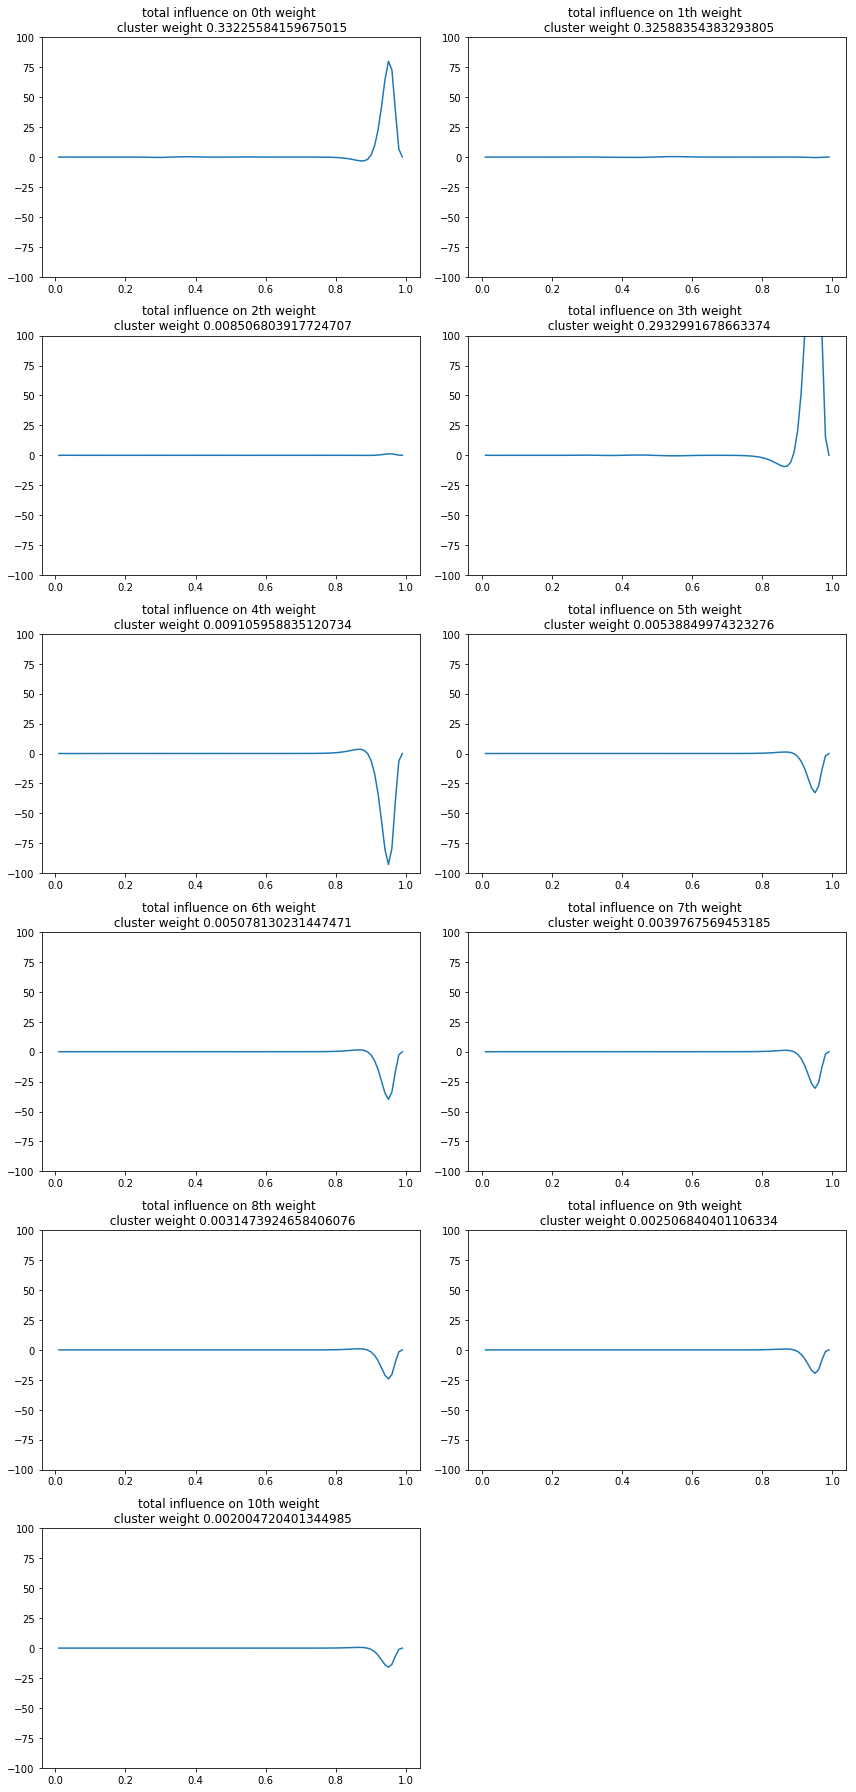

In [53]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('total influence on {}th weight \n cluster weight {}'.format(k, weights[k]))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [54]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [55]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

In [56]:
theta = np.linspace(0.01, 0.99, 100)
influence_n_clust = np.zeros((k_approx, len(theta)))

for k in range(k_approx - 1): 
    influence_n_clust[k, :] += np.dot(np.array([g_eta_nclust]), \
                                           linear_sens.influence_function(theta, k)).flatten()


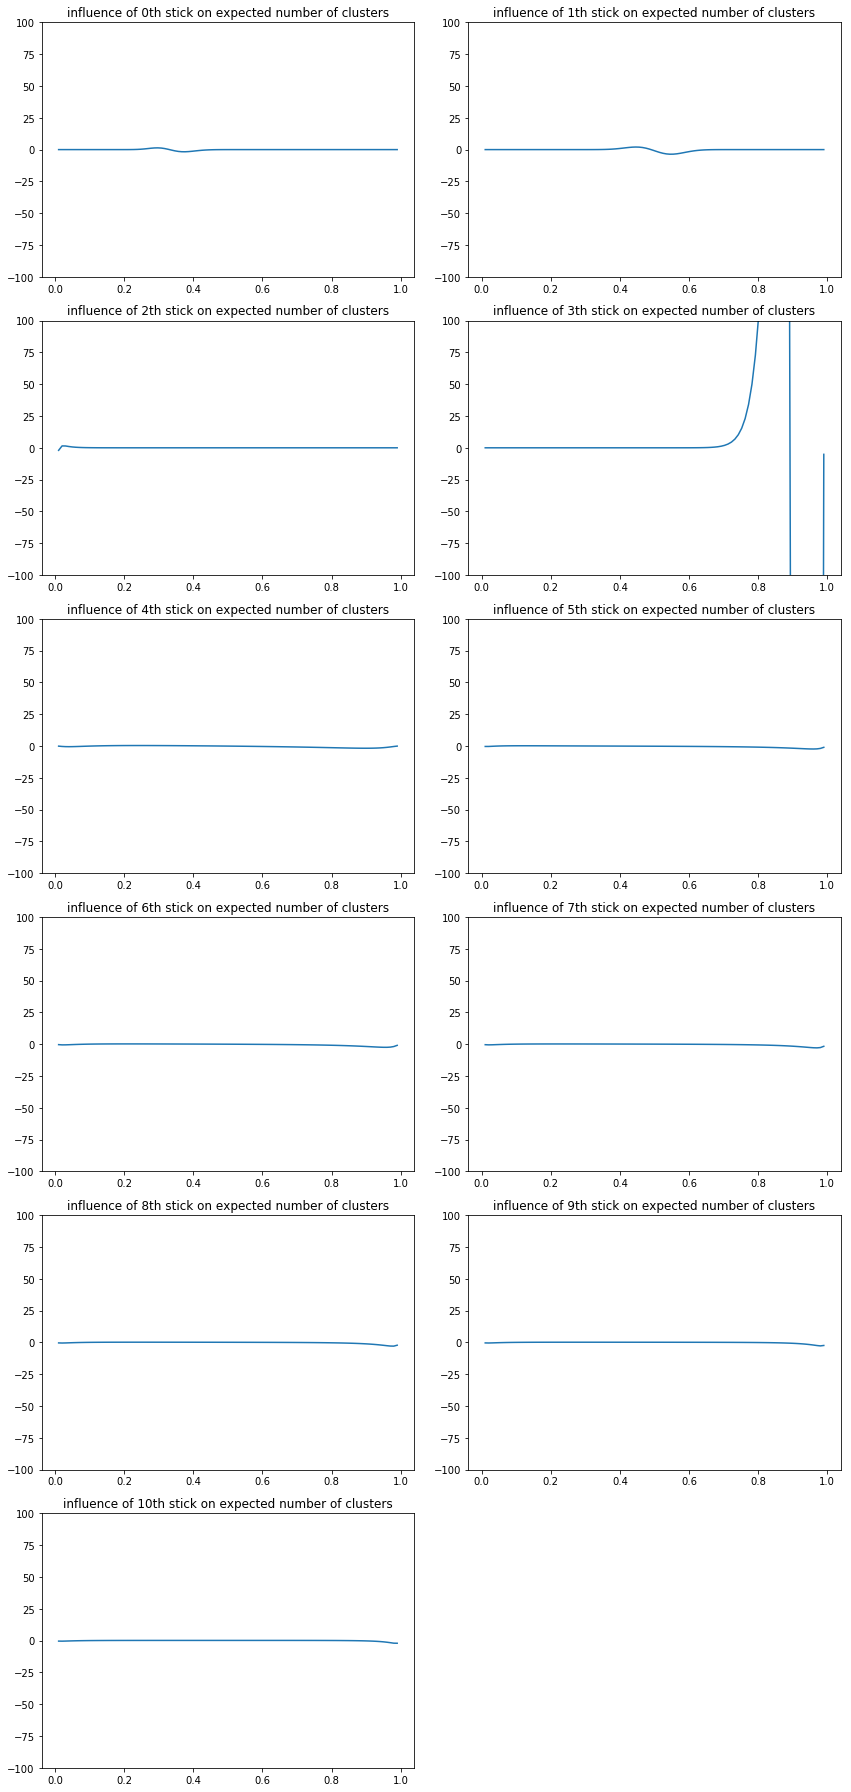

In [57]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, influence_n_clust[k, :])
    axarr[indx1, indx2].set_ylim([-100.0, 100.0])
    
    weights = linear_sens.model.get_e_cluster_probabilities()
    axarr[indx1, indx2].set_title('influence of {}th stick on expected number of clusters'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [58]:
total_influence_n_clust = np.sum(influence_n_clust, axis = 0)

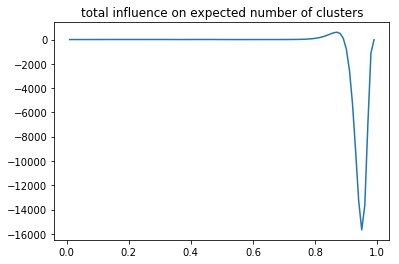

In [59]:
plt.plot(theta, total_influence_n_clust)
plt.title('total influence on expected number of clusters')

(-100, 100)

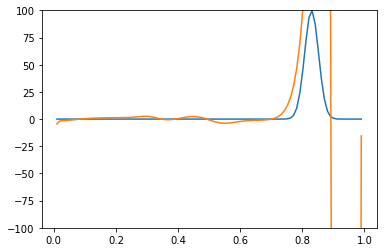

In [60]:
# lets choose a perturbation 
epsilon = 0.001

# u = lambda x : np.exp(-(x - 0.97)**2 / 0.01)
u = lambda x : np.exp(-(x - 0.83)**2 / 0.001)

plt.plot(theta, u(theta) * 100)
plt.plot(theta, total_influence_n_clust)
plt.ylim((-100, 100))

In [61]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(lambda x : u(x) * epsilon)

In [62]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [63]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : u(x) * epsilon)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 9.028010849889903	 Objective: -338.06268881168364
Iter: 10	 RMSE: 9.026541029451433	 Objective: -338.06306726533177
Iter: 20	 RMSE: 9.026560775830898	 Objective: -338.06309343844896
Iter: 30	 RMSE: 9.026180621113038	 Objective: -338.0631421363715
Iter: 40	 RMSE: 9.02589795212072	 Objective: -338.06316397111715
Iter: 50	 RMSE: 9.025775248623097	 Objective: -338.0631688827984
Iter: 60	 RMSE: 9.025796968719593	 Objective: -338.0631698670653
Iter: 70	 RMSE: 9.025797435043767	 Objective: -338.0631699001813
Optimization terminated successfully.
         Current function value: -338.063170
         Iterations: 62
         Function evaluations: 74
         Gradient evaluations: 74
         Current function value: -338.063170
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00013016291433254844, f_diff = 7.66249286243692e-11


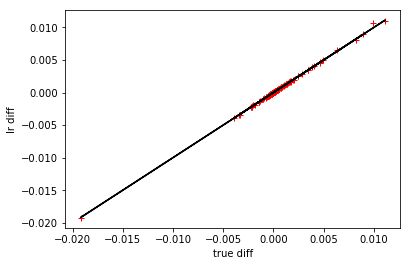

In [64]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


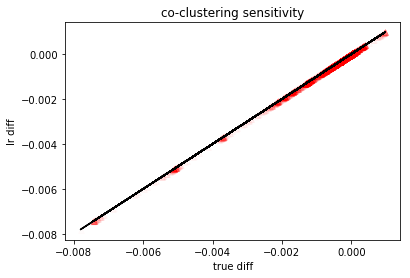

In [65]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


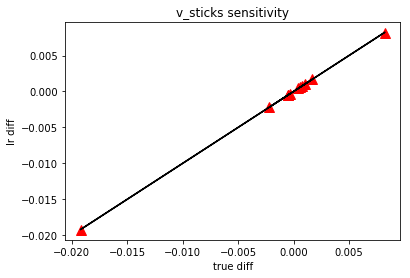

In [66]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


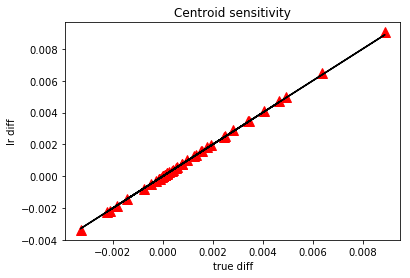

In [67]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')


In [68]:
get_e_number_clusters_from_free_par(model, best_param)

6.290156369623471

In [69]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pert_u_opt_free_param))

perturbed e_number_clusters: 6.327776349703058


In [70]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))

linear response e_number_clusters: 6.321048401149446
